# Assignment 4: Build a Supervised Autoencoder.

### Name: Atul Gupta

### Due Date: Thursday 5/2/2024 11:59PM


PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised learning?



**You are required to build and train a supervised autoencoder look like the following.** You are required to add other layers properly to alleviate overfitting.

<img src="ae.PNG"/>


## 0. You will do the following:

1. Build a standard dense autoencoder, visualize the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.

2. Repeat the above process by training a supervised autoencoder.


## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

2024-05-03 23:40:13.184905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transforms such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
import numpy as np

def to_one_hot(y, num_class=10):
    results = np.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 10K samples;
* a validation set containing 50K samples. (You can use only 10K to save time.)


In [3]:
rand_indices = np.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:20000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Your encoder should contain 3 dense layers and 1 bottleneck layer with 2 as  output size. 
3. Your decoder should contain 4 dense layers with 784 as output size.
4. You can choose different number of hidden units in dense layers.
5. Do not add other layers (no activation layers), you may add them in later sections.
6. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
7. Try to achieve a validation loss as low as possible.
8. Evaluate the model on the test set.
9. Visualize the low-dim features and reconstructions.


### 2.1. Build the model (20 points)

In [4]:
from keras.layers import *
from keras import models

input_img = Input(shape=(784,), name='input_img')

encode1 = Dense(448, activation='relu', name='encode1')(input_img)
encode2 = Dense(256, activation='relu', name='encode2')(encode1)
encode3 = Dense(96, activation='relu', name='encode3')(encode2)

bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)

decode1 = Dense(96, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(256, activation='relu', name='decode2')(decode1)
decode3 = Dense(448, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)


ae = models.Model(input_img, decode4)

ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 784)]             0         
                                                                 
 encode1 (Dense)             (None, 448)               351680    
                                                                 
 encode2 (Dense)             (None, 256)               114944    
                                                                 
 encode3 (Dense)             (None, 96)                24672     
                                                                 
 bottleneck (Dense)          (None, 2)                 194       
                                                                 
 decode1 (Dense)             (None, 96)                288       
                                                                 
 decode2 (Dense)             (None, 256)               24832 

2024-05-03 23:40:15.137785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils import model_to_dot, plot_model

SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.pdf'
)

# you can find the file "unsupervised_ae.pdf" in the current directory.

### 2.2. Train the model and tune the hyper-parameters (5 points)

In [6]:
from tensorflow.keras import optimizers

# learning_rate = 1E-3 # to be tuned!
learning_rate = 0.001

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(learning_rate=learning_rate))

In [7]:
history = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))

Epoch 1/100
79/79 [==============================] - 1s 10ms/step - loss: 0.0759 - val_loss: 0.0680
Epoch 2/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0670 - val_loss: 0.0656
Epoch 3/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0643 - val_loss: 0.0625
Epoch 4/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0617 - val_loss: 0.0614
Epoch 5/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0593 - val_loss: 0.0584
Epoch 6/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0568 - val_loss: 0.0573
Epoch 7/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0553 - val_loss: 0.0547
Epoch 8/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0543 - val_loss: 0.0537
Epoch 9/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0527 - val_loss: 0.0538
Epoch 10/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0514 - val_loss: 0.0523
Epoch 11

Epoch 83/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0351 - val_loss: 0.0399
Epoch 84/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0351 - val_loss: 0.0415
Epoch 85/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0352 - val_loss: 0.0400
Epoch 86/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0350 - val_loss: 0.0397
Epoch 87/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0349 - val_loss: 0.0404
Epoch 88/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0350 - val_loss: 0.0392
Epoch 89/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0349 - val_loss: 0.0397
Epoch 90/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0348 - val_loss: 0.0408
Epoch 91/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0347 - val_loss: 0.0392
Epoch 92/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0347 - val_loss: 0.0389


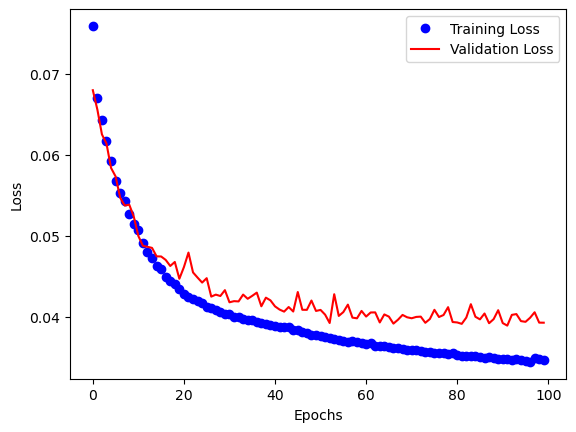

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.3. Visualize the reconstructed test images (5 points)

313/313 [==============================] - 0s 1ms/step


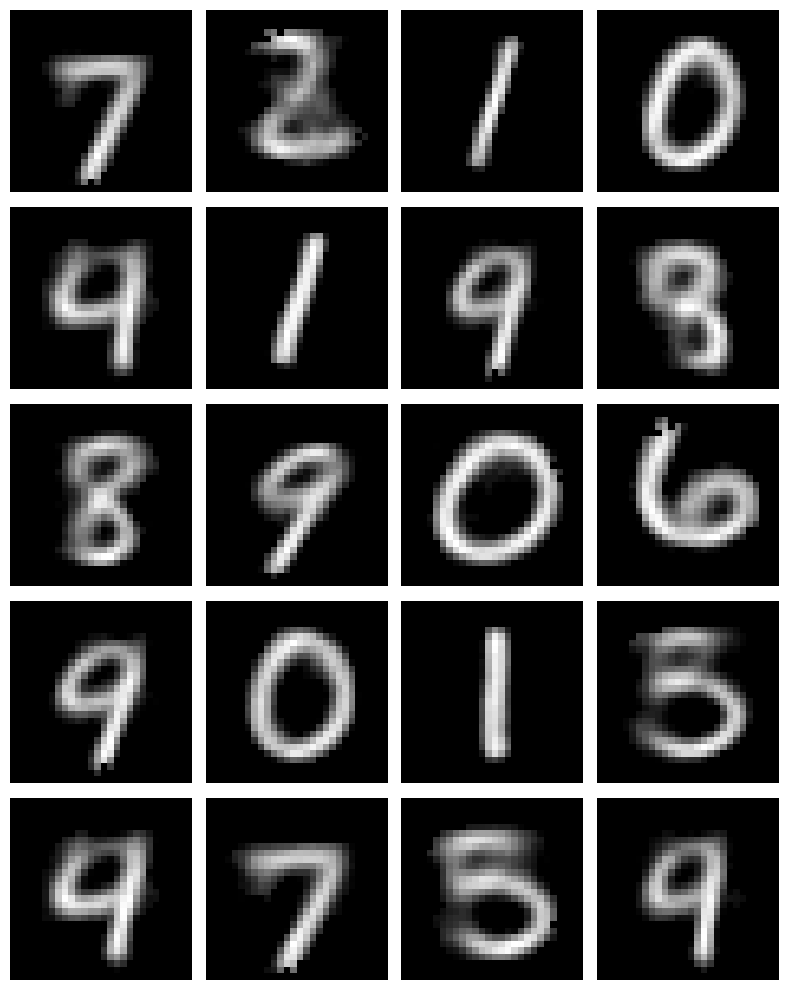

In [9]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 2.4. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [10]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

313/313 [==============================] - 0s 1ms/step - loss: 0.0392
loss = 0.03920411691069603


### 2.5. Visualize the low-dimensional features

In [11]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 784)]             0         
                                                                 
 encode1 (Dense)             (None, 448)               351680    
                                                                 
 encode2 (Dense)             (None, 256)               114944    
                                                                 
 encode3 (Dense)             (None, 96)                24672     
                                                                 
 bottleneck (Dense)          (None, 2)                 194       
                                                                 
Total params: 491,490
Trainable params: 491,490
Non-trainable params: 0
_________________________________________________________________


In [12]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

313/313 [==============================] - 0s 819us/step
Shape of encoded_test: (10000, 2)


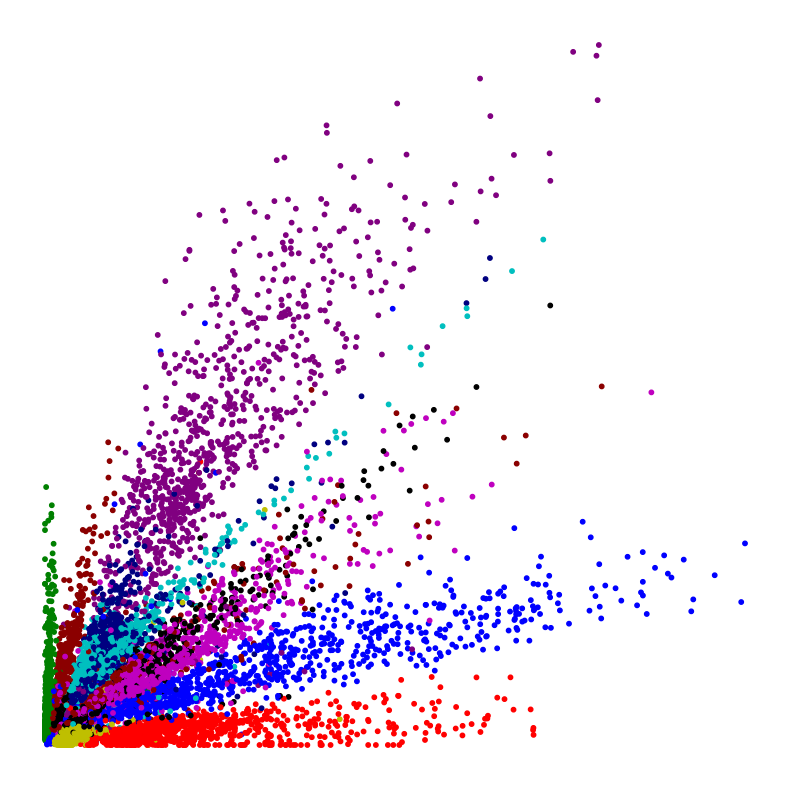

In [13]:
colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantitatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative? (10 points)

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [14]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

313/313 [==============================] - 0s 801us/step
Shape of f_tr: (10000, 2)
Shape of f_te: (10000, 2)


In [15]:
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [16]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1E-3),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 [==============================] - 1s 1ms/step - loss: 1.2875 - acc: 0.6051 - val_loss: 1.0026 - val_acc: 0.6487
Epoch 2/30
313/313 [==============================] - 0s 1ms/step - loss: 0.9638 - acc: 0.7110 - val_loss: 0.9264 - val_acc: 0.6824
Epoch 3/30
313/313 [==============================] - 0s 1ms/step - loss: 0.8865 - acc: 0.7366 - val_loss: 0.8461 - val_acc: 0.7172
Epoch 4/30
313/313 [==============================] - 0s 1ms/step - loss: 0.8315 - acc: 0.7431 - val_loss: 0.8152 - val_acc: 0.7316
Epoch 5/30
313/313 [==============================] - 0s 1ms/step - loss: 0.7882 - acc: 0.7528 - val_loss: 0.8378 - val_acc: 0.7154
Epoch 6/30
313/313 [==============================] - 0s 1ms/step - loss: 0.7570 - acc: 0.7607 - val_loss: 0.7698 - val_acc: 0.7312
Epoch 7/30
313/313 [==============================] - 0s 1ms/step - loss: 0.7354 - acc: 0.7655 - val_loss: 0.7591 - val_acc: 0.7317
Epoch 8/30
313/313 [==============================] - 0s 1ms/step - loss: 0.

### Conclusion

Using the 2D features, the validation accuracy is 60~70%. Recall that using the original data, the accuracy is about 97%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same. You can use convolutional layers as well.) You are required to add other layers properly to alleviate overfitting.

<img src="ae.PNG"/>


### 4.1. Build the network (30 points)

In [17]:
# build the supervised autoencoder network
from keras.layers import *
from keras import models

input_img = Input(shape=(784,), name='input_img')

# encoder network

encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode2 = Dense(64, activation='relu', name='encode2')(encode1)
encode3 = Dense(32, activation='relu', name='encode3')(encode2)

# The width of the bottleneck layer must be exactly 2.

bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)

# decoder network
decode1 = Dense(32, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(64, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)


# build a classifier upon the bottleneck layer
classifier1 = Dense(128, activation='relu', name='classifier1')(bottleneck)
classifier2 = Dense(64, activation='relu', name='classifier2')(classifier1)
classifier3 = Dense(10, activation='softmax', name='classifier3')(classifier2)

In [18]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode4, classifier3])

sae.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 784)]        0           []                               
                                                                                                  
 encode1 (Dense)                (None, 128)          100480      ['input_img[0][0]']              
                                                                                                  
 encode2 (Dense)                (None, 64)           8256        ['encode1[0][0]']                
                                                                                                  
 encode3 (Dense)                (None, 32)           2080        ['encode2[0][0]']                
                                                                                            

In [19]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils import model_to_dot, plot_model

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights. 

In [20]:
from tensorflow.keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1, 0.5], # to be tuned
            optimizer=optimizers.RMSprop(learning_rate=1E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

Epoch 1/100
313/313 [==============================] - 2s 3ms/step - loss: 0.9695 - decode4_loss: 0.0755 - classifier3_loss: 1.7879 - val_loss: 0.8546 - val_decode4_loss: 0.0709 - val_classifier3_loss: 1.5674
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 0.7374 - decode4_loss: 0.0692 - classifier3_loss: 1.3366 - val_loss: 0.6970 - val_decode4_loss: 0.0677 - val_classifier3_loss: 1.2586
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 0.5792 - decode4_loss: 0.0652 - classifier3_loss: 1.0279 - val_loss: 0.5543 - val_decode4_loss: 0.0636 - val_classifier3_loss: 0.9814
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 0.3903 - decode4_loss: 0.0609 - classifier3_loss: 0.6588 - val_loss: 0.3754 - val_decode4_loss: 0.0603 - val_classifier3_loss: 0.6302
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 0.2586 - decode4_loss: 0.0587 - classifier3_loss: 0.3997 - val_loss: 0.2930 - val_decode4

313/313 [==============================] - 1s 3ms/step - loss: 0.0672 - decode4_loss: 0.0498 - classifier3_loss: 0.0347 - val_loss: 0.6963 - val_decode4_loss: 0.0505 - val_classifier3_loss: 1.2915
Epoch 41/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0677 - decode4_loss: 0.0495 - classifier3_loss: 0.0364 - val_loss: 0.7601 - val_decode4_loss: 0.0504 - val_classifier3_loss: 1.4195
Epoch 42/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0693 - decode4_loss: 0.0495 - classifier3_loss: 0.0395 - val_loss: 0.6232 - val_decode4_loss: 0.0507 - val_classifier3_loss: 1.1451
Epoch 43/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0731 - decode4_loss: 0.0496 - classifier3_loss: 0.0470 - val_loss: 0.4993 - val_decode4_loss: 0.0510 - val_classifier3_loss: 0.8965
Epoch 44/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0710 - decode4_loss: 0.0495 - classifier3_loss: 0.0430 - val_loss: 0.5610 - val_decode4_loss: 0

313/313 [==============================] - 1s 3ms/step - loss: 0.0683 - decode4_loss: 0.0474 - classifier3_loss: 0.0420 - val_loss: 0.9759 - val_decode4_loss: 0.0494 - val_classifier3_loss: 1.8530
Epoch 80/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0659 - decode4_loss: 0.0473 - classifier3_loss: 0.0372 - val_loss: 0.7379 - val_decode4_loss: 0.0491 - val_classifier3_loss: 1.3775
Epoch 81/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0680 - decode4_loss: 0.0475 - classifier3_loss: 0.0412 - val_loss: 0.7515 - val_decode4_loss: 0.0497 - val_classifier3_loss: 1.4036
Epoch 82/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0664 - decode4_loss: 0.0472 - classifier3_loss: 0.0383 - val_loss: 0.6713 - val_decode4_loss: 0.0492 - val_classifier3_loss: 1.2442
Epoch 83/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0671 - decode4_loss: 0.0476 - classifier3_loss: 0.0391 - val_loss: 0.8750 - val_decode4_loss: 0

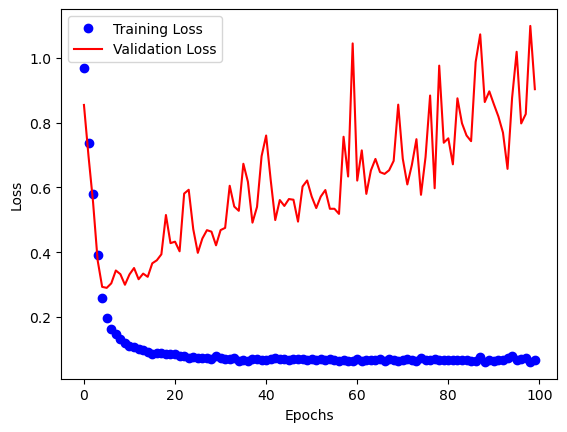

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question  (10 points)

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

You can use the new model without overfitting for the following sections.

Answer: The validation loss keeps decreasing continously. That means there is no overfitting. We can make the curve smoother by adding early stopping, normalization and dropout etc.

In [22]:
# build the supervised autoencoder network
from keras.layers import *
from keras import models

input_img = Input(shape=(784,), name='input_img')

# encoder network
encode1 = Dense(128, activation='relu', name='encode1')(input_img)
dropout_en1 = Dropout(0.3, name='dropout_en1')(encode1)
encode2 = Dense(64, activation='relu', name='encode2')(dropout_en1)
dropout_en2 = Dropout(0.3, name='dropout_en2')(encode2)
encode3 = Dense(32, activation='relu', name='encode3')(dropout_en2)
dropout_en3 = Dropout(0.5, name='dropout_en3')(encode3)
batch_norm_en = BatchNormalization(name='batch_norm_en')(dropout_en3)

# The width of the bottleneck layer must be exactly 2.

bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)

# decoder network
decode1 = Dense(32, activation='relu', name='decode1')(bottleneck)
dropout_de1 = Dropout(0.3, name='dropout_de1')(decode1)
decode2 = Dense(64, activation='relu', name='decode2')(dropout_de1)
dropout_de2 = Dropout(0.3, name='dropout_de2')(decode2)
decode3 = Dense(128, activation='relu', name='decode3')(dropout_de2)
dropout_de3 = Dropout(0.5, name='dropout_de3')(decode3)
batch_norm_de = BatchNormalization(name='batch_norm_de')(dropout_de3)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)

# build a classifier upon the bottleneck layer
classifier1 = Dense(128, activation='relu', name='classifier1')(bottleneck)
dropout_cl1 = Dropout(0.5, name='dropout_cl1')(classifier1)
classifier2 = Dense(64, activation='relu', name='classifier2')(dropout_cl1)
dropout_cl2 = Dropout(0.5, name='dropout_cl2')(classifier2)
classifier3 = Dense(10, activation='softmax', name='classifier3')(dropout_cl2)

In [23]:
# connect the input and the two outputs
sae_new = models.Model(input_img, [decode4, classifier3])

sae_new.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 784)]        0           []                               
                                                                                                  
 encode1 (Dense)                (None, 128)          100480      ['input_img[0][0]']              
                                                                                                  
 dropout_en1 (Dropout)          (None, 128)          0           ['encode1[0][0]']                
                                                                                                  
 encode2 (Dense)                (None, 64)           8256        ['dropout_en1[0][0]']            
                                                                                            

In [24]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(sae_new, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae_new, show_shapes=False,
    to_file='supervised_ae_new.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

In [25]:
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping

sae_new.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1.0, 0.5], # to be tuned
            optimizer=optimizers.Adam(learning_rate=0.001))

stop_early = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

history_new = sae_new.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]),
                  callbacks=[stop_early])

Epoch 1/100
313/313 [==============================] - 1s 3ms/step - loss: 1.0056 - decode4_loss: 0.0680 - classifier3_loss: 1.8752 - val_loss: 0.7209 - val_decode4_loss: 0.0611 - val_classifier3_loss: 1.3196
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 0.6843 - decode4_loss: 0.0601 - classifier3_loss: 1.2484 - val_loss: 0.4949 - val_decode4_loss: 0.0573 - val_classifier3_loss: 0.8751
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 0.5306 - decode4_loss: 0.0573 - classifier3_loss: 0.9465 - val_loss: 0.4093 - val_decode4_loss: 0.0556 - val_classifier3_loss: 0.7073
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4517 - decode4_loss: 0.0561 - classifier3_loss: 0.7911 - val_loss: 0.3505 - val_decode4_loss: 0.0545 - val_classifier3_loss: 0.5919
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4061 - decode4_loss: 0.0554 - classifier3_loss: 0.7014 - val_loss: 0.3281 - val_decode4

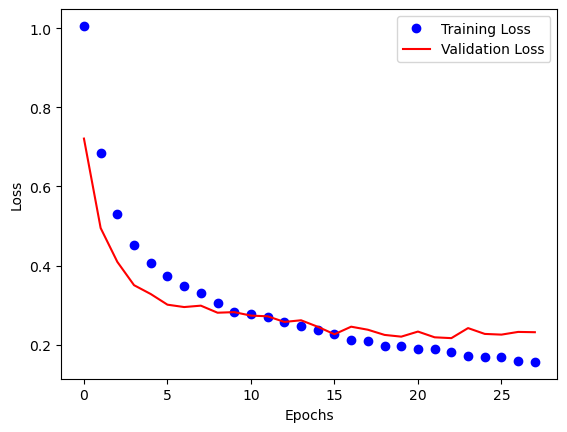

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history_new.history['loss']
val_loss = history_new.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim(0.1, 0.3)
plt.legend()
plt.show()

### 4.3. Visualize the reconstructed test images

313/313 [==============================] - 0s 867us/step


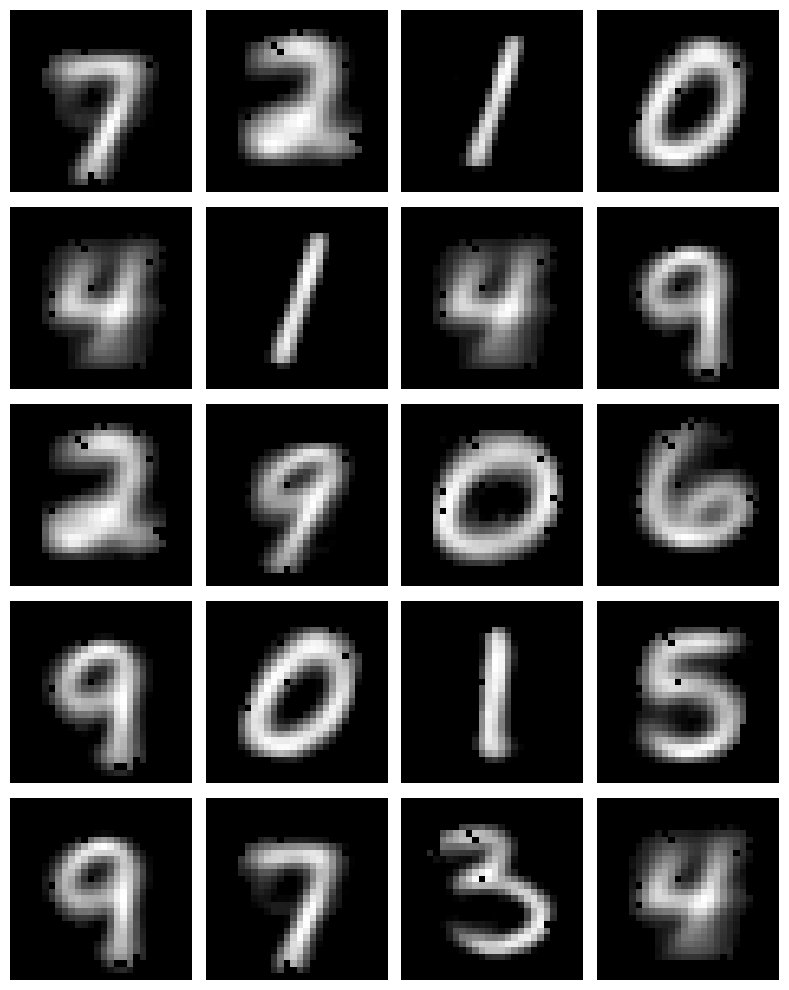

In [27]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 4.4. Visualize the low-dimensional features



In [28]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 784)]             0         
                                                                 
 encode1 (Dense)             (None, 128)               100480    
                                                                 
 dropout_en1 (Dropout)       (None, 128)               0         
                                                                 
 encode2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_en2 (Dropout)       (None, 64)                0         
                                                                 
 encode3 (Dense)             (None, 32)                2080      
                                                                 
 bottleneck (Dense)          (None, 2)                 66  

313/313 [==============================] - 0s 510us/step
Shape of encoded_test: (10000, 2)


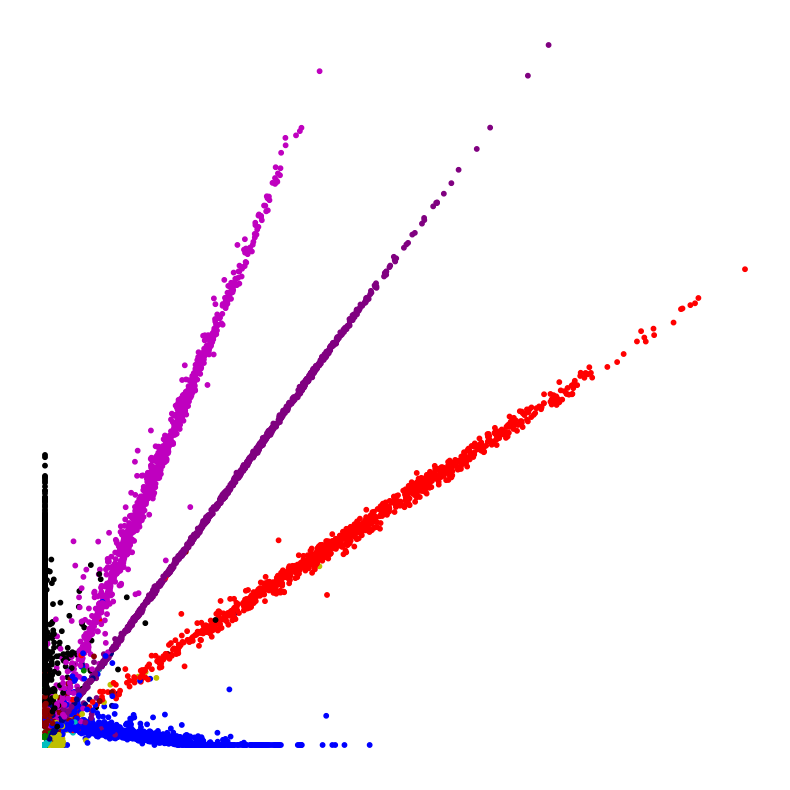

In [29]:
# extract test features
encoded_test = sae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.5. Are the learned low-dim features discriminative? (10 points)

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the validation and test set.



In [30]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

313/313 [==============================] - 0s 528us/step


In [31]:
# build a classifier which takes the 2D features as input
from keras.layers import *
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
dropout1 = Dropout(0.5)(hidden1)
hidden2 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(hidden2)
output = Dense(10, activation='softmax')(dropout2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 128)               384       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 9,290
Trainable params: 9,290
Non-trainable p

In [32]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1E-3),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 [==============================] - 1s 1ms/step - loss: 1.7740 - acc: 0.4842 - val_loss: 0.8545 - val_acc: 0.8557
Epoch 2/30
313/313 [==============================] - 0s 1ms/step - loss: 0.6460 - acc: 0.8347 - val_loss: 0.4323 - val_acc: 0.9371
Epoch 3/30
313/313 [==============================] - 0s 1ms/step - loss: 0.3403 - acc: 0.9158 - val_loss: 0.4102 - val_acc: 0.9391
Epoch 4/30
313/313 [==============================] - 0s 1ms/step - loss: 0.2305 - acc: 0.9410 - val_loss: 0.4557 - val_acc: 0.9393
Epoch 5/30
313/313 [==============================] - 0s 1ms/step - loss: 0.1924 - acc: 0.9514 - val_loss: 0.4783 - val_acc: 0.9401
Epoch 6/30
313/313 [==============================] - 0s 1ms/step - loss: 0.1602 - acc: 0.9579 - val_loss: 0.5243 - val_acc: 0.9406
Epoch 7/30
313/313 [==============================] - 0s 1ms/step - loss: 0.1485 - acc: 0.9621 - val_loss: 0.5582 - val_acc: 0.9407
Epoch 8/30
313/313 [==============================] - 0s 1ms/step - loss: 0.

#### Remark: (10 points)

The validation accuracy must be above 90%. It means the low-dim features learned by the supervised autoencoder are very effective.

In [33]:
# evaluate your model on the never-seen-before test data
# write your code here:
[loss, accuracy] = classifier.evaluate(f_te, y_test_vec)

print(f'loss = {loss}')
print(f'accuracy = {accuracy}')

313/313 [==============================] - 0s 504us/step - loss: 0.8452 - acc: 0.9408
loss = 0.8451735377311707
accuracy = 0.9408000111579895
